<a href="https://colab.research.google.com/github/tkd8973/ML_Project/blob/main/ML/%EC%95%84%ED%8C%8C%ED%8A%B8_%EC%8B%A4%EA%B1%B0%EB%9E%98%EA%B0%80_1%EC%9B%94_%EB%8D%B0%EC%9D%B4%ED%84%B0_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 아파트 실거래가 예측

In [ ]:
# INPUT : 도/면적/계약년월/건축년도/유형
# OUTPUT : 금액
# EX) 서울 /50 / 2020 / 직거래 → 100억?
# EX2) 경기도/ 30 / 1990/ 중개 → ???억

# 시군구 전처리 - ex) 경기도 OO군 OO시 → 경기도 df[’’].split(’ ‘)[0]
# 거래유형 전처리 - 중개 : 0 직 : 1
# 피쳐엔지니어링 - ex) 면적당 금액?

In [ ]:
#@title 폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (8,003 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 128285 files and di

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
#@title 1월 데이터
# 시군구 - 전용면적, 계약년월, 거래 금액, 건축년도, 거래유형
df_apt1 = pd.read_csv('https://github.com/jaiwon880/ML_Projiect/raw/main/Data/%EC%95%84%ED%8C%8C%ED%8A%B8_%EB%A7%A4%EB%A7%A4__%EC%8B%A4%EA%B1%B0%EB%9E%98%EA%B0%80_20230321134107_1%EC%9B%94.csv')
df_apt1

,시군구,전용면적(㎡),계약년월,계약일,거래금액(만원),건축년도,거래유형
0,강원도 강릉시 견소동,84.930,202301,4,"25,000",1997.0,중개거래
1,강원도 강릉시 견소동,84.990,202301,5,"29,800",2005.0,중개거래
2,강원도 강릉시 견소동,84.990,202301,25,"28,500",2005.0,중개거래
3,강원도 강릉시 교동,59.860,202301,4,"20,000",2002.0,직거래
4,강원도 강릉시 교동,59.840,202301,11,"25,000",2002.0,중개거래
...,...,...,...,...,...,...,...
19997,충청북도 충주시 호암동,84.809,202301,10,"33,000",2019.0,중개거래
19998,충청북도 충주시 호암동,84.809,202301,10,"33,000",2019.0,중개거래
19999,충청북도 충주시 호암동,84.960,202301,8,"38,500",2019.0,중개거래
20000,충청북도 충주시 호암동,84.890,202301,16,"37,000",2019.0,중개거래


In [ ]:
# df_apt1[['시/도', '시군구', '읍면동', '리']] = df_apt1['시군구'].str.split(' ', n=4, expand=True)
# df_apt1.drop('시군구', axis=1, inplace=True)
# df_apt1

In [ ]:
df_apt1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20002 entries, 0 to 20001
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시군구       20002 non-null  object 
 1   전용면적(㎡)   20002 non-null  float64
 2   계약년월      20002 non-null  int64  
 3   계약일       20002 non-null  int64  
 4   거래금액(만원)  20002 non-null  object 
 5   건축년도      19998 non-null  float64
 6   거래유형      20002 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.1+ MB


In [ ]:
df_apt1.describe() # 54억 ^_^... 700마넌넌

,전용면적(㎡),계약년월,계약일,건축년도
count,20002.000000,20002.0,20002.000000,19998.000000
mean,73.051181,202301.0,16.970053,2006.036354
std,23.592464,0.0,8.730426,10.753980
min,11.790000,202301.0,1.000000,1968.000000
25%,59.775000,202301.0,10.000000,1997.000000
50%,75.303600,202301.0,17.000000,2006.000000
75%,84.950000,202301.0,26.000000,2017.000000
max,258.680000,202301.0,31.000000,2023.000000


In [ ]:
df_apt1['거래금액(만원)'].str.strip().replace(' ','')
df_apt1

,시군구,전용면적(㎡),계약년월,계약일,거래금액(만원),건축년도,거래유형
0,강원도 강릉시 견소동,84.930,202301,4,"25,000",1997.0,중개거래
1,강원도 강릉시 견소동,84.990,202301,5,"29,800",2005.0,중개거래
2,강원도 강릉시 견소동,84.990,202301,25,"28,500",2005.0,중개거래
3,강원도 강릉시 교동,59.860,202301,4,"20,000",2002.0,직거래
4,강원도 강릉시 교동,59.840,202301,11,"25,000",2002.0,중개거래
...,...,...,...,...,...,...,...
19997,충청북도 충주시 호암동,84.809,202301,10,"33,000",2019.0,중개거래
19998,충청북도 충주시 호암동,84.809,202301,10,"33,000",2019.0,중개거래
19999,충청북도 충주시 호암동,84.960,202301,8,"38,500",2019.0,중개거래
20000,충청북도 충주시 호암동,84.890,202301,16,"37,000",2019.0,중개거래


In [ ]:
#@title 평단가 금액
df_apt1["거래금액(만원)"] = df_apt1["거래금액(만원)"].str.replace(",", "").astype(int) # 거래금액 컬럼의 쉼표를 제거하고 정수형으로 변환
df_apt1["평단가"] = (df_apt1["거래금액(만원)"] / df_apt1["전용면적(㎡)"]) * 3.3 # 평단가 계산하여 새로운 컬럼 추가
df_apt1["평단가"]

0         971.388202
1        1157.077303
2        1106.600777
3        1102.572670
4        1378.676471
            ...     
19997    1284.061833
19998    1284.061833
19999    1495.409605
20000    1438.331959
20001    1584.745763
Name: 평단가, Length: 20002, dtype: float64

In [ ]:
# df_apt1 = df_apt1.drop('시군구', axis=1)
df_apt1['거래유형'] = df_apt1['거래유형'].replace({'중개거래': 0, '직거래': 1})

In [ ]:
df_apt1

,시군구,전용면적(㎡),계약년월,계약일,거래금액(만원),건축년도,거래유형,평단가
0,강원도 강릉시 견소동,84.930,202301,4,25000,1997.0,0,971.388202
1,강원도 강릉시 견소동,84.990,202301,5,29800,2005.0,0,1157.077303
2,강원도 강릉시 견소동,84.990,202301,25,28500,2005.0,0,1106.600777
3,강원도 강릉시 교동,59.860,202301,4,20000,2002.0,1,1102.572670
4,강원도 강릉시 교동,59.840,202301,11,25000,2002.0,0,1378.676471
...,...,...,...,...,...,...,...,...
19997,충청북도 충주시 호암동,84.809,202301,10,33000,2019.0,0,1284.061833
19998,충청북도 충주시 호암동,84.809,202301,10,33000,2019.0,0,1284.061833
19999,충청북도 충주시 호암동,84.960,202301,8,38500,2019.0,0,1495.409605
20000,충청북도 충주시 호암동,84.890,202301,16,37000,2019.0,0,1438.331959


In [ ]:
#@title 결측치 건축년도 4개 삭제 
df_apt1.isna().sum()
df_apt1.dropna(inplace=True)

In [ ]:
df_apt1.isna().sum()

시군구         0
전용면적(㎡)     0
계약년월        0
계약일         0
거래금액(만원)    0
건축년도        0
거래유형        0
평단가         0
dtype: int64

In [ ]:
df_apt1['금리'] = df_apt1.apply(lambda x: 3.25 if ((x['계약년월']== 202301) & (x['계약일'] < 13)) else 3.5, axis=1)

,시군구,전용면적(㎡),계약년월,계약일,거래금액(만원),건축년도,거래유형,평단가,금리
12328,서울특별시 강남구 신사동,68.240,202301,6,70000,2002.0,0,3385.111372,3.25
12329,서울특별시 강남구 신사동,60.938,202301,26,55000,2002.0,0,2978.437100,3.50


In [ ]:
# 계약년월과 계약일을 합쳐서 datetime으로 변환
df_apt1['날짜'] = pd.to_datetime(df_apt1['계약년월'].astype(str) + df_apt1['계약일'].astype(str), format='%Y%m%d')

# 계약년월과 계약일 열 삭제 후 인덱스 설정
df_apt1 = df_apt1.drop(['계약년월', '계약일'], axis=1)
df_apt1 = df_apt1.set_index('날짜')


,시군구,전용면적(㎡),거래금액(만원),건축년도,거래유형,평단가,금리
날짜,,,,,,,
2023-01-04,강원도 강릉시 견소동,84.930,25000,1997.0,0,971.388202,3.25
2023-01-05,강원도 강릉시 견소동,84.990,29800,2005.0,0,1157.077303,3.25
2023-01-25,강원도 강릉시 견소동,84.990,28500,2005.0,0,1106.600777,3.50
2023-01-04,강원도 강릉시 교동,59.860,20000,2002.0,1,1102.572670,3.25
2023-01-11,강원도 강릉시 교동,59.840,25000,2002.0,0,1378.676471,3.25
...,...,...,...,...,...,...,...
2023-01-10,충청북도 충주시 호암동,84.809,33000,2019.0,0,1284.061833,3.25
2023-01-10,충청북도 충주시 호암동,84.809,33000,2019.0,0,1284.061833,3.25
2023-01-08,충청북도 충주시 호암동,84.960,38500,2019.0,0,1495.409605,3.25


In [ ]:
df_apt1[df_apt1['시군구']=='서울특별시 강남구 신사동']

,시군구,전용면적(㎡),거래금액(만원),건축년도,거래유형,평단가,금리
날짜,,,,,,,
2023-01-06,서울특별시 강남구 신사동,68.240,70000,2002.0,0,3385.111372,3.25
2023-01-26,서울특별시 강남구 신사동,60.938,55000,2002.0,0,2978.437100,3.50


In [ ]:
#@title 훈련셋 테스트셋 나누기

X = df_apt1.drop("거래금액(만원)", axis=1)
y = df_apt1[['거래금액(만원)']]


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=100)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15998, 5) (4000, 5) (15998, 1) (4000, 1)


In [ ]:
#@title  선형회귀

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
#@title RMSE 평가
def rmse_error(y, y_pred):
  rmse = mean_squared_error(y, y_pred) ** 0.5
  return rmse

print(rmse_error(lr.predict(X_train),y_train))
print(rmse_error(lr.predict(X_test),y_test))

10358.795577275036
9624.213347660074


In [ ]:
#@title XGBRegressor
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=100)  
model_xgb.fit(X_train, y_train) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=100, ...)

In [ ]:
y_pred = model_xgb.predict(X_test)  # 모델 예측
mse = mean_squared_error(y_test, y_pred)  # 모델 평가
print("MSE: %.2f" % mse)

MSE: 3420220.67


In [ ]:
#@title RMSE 평가
def rmse_error(y, y_pred):
  rmse = mean_squared_error(y, y_pred) ** 0.5
  return rmse

print(rmse_error(model_xgb.predict(X_train),y_train))
print(rmse_error(model_xgb.predict(X_test),y_test))

1662.7940344759206
1849.383862214306


In [ ]:
# 필요한 라이브러리 import
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# 데이터 로드 및 전처리
# df_apt1['거래년월'] = df_apt1['계약년월'].apply(lambda x: int(str(x)[:6]))
X = df_apt1.drop(['거래금액(만원)'], axis=1)  # 독립변수
y = df_apt1['거래금액(만원)']  # 종속변수
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# # 피쳐 엔지니어링
# X_train['평균매매가격'] = X_train['거래금액(만원)'] / X_train['전용면적(㎡)']
# X_test['평균매매가격'] = X_test['거래금액(만원)'] / X_test['전용면적(㎡)']

# 피쳐 셀렉션
selector = SelectKBest(f_regression, k=5)
selector.fit(X_train, y_train)
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 모델 초기화 및 학습
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=123)
model.fit(X_train, y_train)

# 모델 평가 및 예측
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)

# z-점수 계산
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_z = (X - X_mean) / X_std
print(X_z)

KeyError: ignored

In [ ]:
# 새로운 데이터에 대한 예측
new_data = pd.DataFrame({
    '전용면적(㎡)': [84.930],
    '건축년도': [2005.0],
    '거래유형': [0],
    '평단가': [971.388202],
    '금리': [3.75]
})
predicted_price = model_xgb.predict(new_data)  # 새로운 데이터에 대한 예측
print("Predicted price: %.2f" % predicted_price)  # 예측된 아파트 실거래가 출력

Predicted price: 25610.66


In [ ]:
# #@title 
# # 거래금액(만원)은 연속적인 값을 가짐 -> Regressor
# # 거래유형은 이진 분류 문제, 0 또는 1의 값으로 범주형 변수 -> Classifier 

# # from tqdm import tqdm
# # from sklearn.model_selection import TimeSeriesSplit

# # def rmse_cv(model):
# #     tscv = TimeSeriesSplit(n_splits=10)
# #     rmse_list = []
# #     model_name = model.__class__.__name__
# #     for _, (train_index, test_index) in tqdm(enumerate(tscv.split(X_train), start=1), desc=f'{model_name} Cross Validations...', total=10):
# #         X_train, X_test = X_train.iloc[train_index], X_train.iloc[test_index]
# #         y_train, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
# #         clf = model.fit(X_train, y_train)
# #         pred = clf.predict(X_test)
# #         rmse = rmse_error(y_test, pred) 
# #         rmse_list.append(rmse)
# #     return model_name, rmse_list

# # def print_rmse_score(model):
# #     # cv별 프린팅, 평균 저장
# #     model_name, score = rmse_cv(model)
# #     for i, r in enumerate(score, start=1):
# #         print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
# #     print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
# #     print('='*40)
# #     return model_name, np.mean(score)

# model_xgb = xgb.XGBClassifier(random_state=100)
# model_xgb.fit(X_train, y_train)

# train_pred = model_xgb.predict(X_train)
# test_pred = model_xgb.predict(X_test)

# from sklearn.metrics import accuracy_score, confusion_matrix


# # 학습율
# print(accuracy_score(y_train, train_pred))
# print(accuracy_score(y_test, test_pred))


# model = xgb.XGBClassifier(
#     n_estimators=500,
#     max_depth=10,
#     n_jobs=-1,
#     random_state=23)
# model.fit(X_train, y_train)

# # 변수 조정 후 다시 예측
# train_pred = model.predict(X_train)
# test_pred = model.predict(X_test)

# # 학습율
# print(accuracy_score(y_train, train_pred))
# print(accuracy_score(y_test, test_pred))


# print(confusion_matrix(y_test, test_pred))
# cf_matrix = confusion_matrix(y_test, test_pred)
# cf_matrix
# group_names = ['TN','FP','FN','TP']
# group_counts = ["{0:0.0f}".format(value) for value in
#                 cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
# labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#           zip(group_names,group_counts,group_percentages)]
# labels = np.asarray(labels).reshape(2,2)
# sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm')
# plt.ylabel('True')
# plt.xlabel('Predicted')
# plt.show()



# # models = []
# # scores = []
# # for model in [xgb_model]:
# #     model_name, mean_score = print_rmse_score(model)
# #     models.append(model_name)
# #     scores.append(mean_score)

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPyth

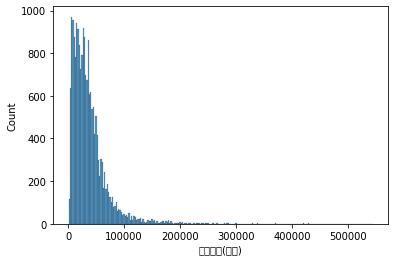

In [ ]:
sns.histplot(df_apt1['거래금액(만원)'])
plt.show()

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 13217 (\N{SQUARE M SQUARED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


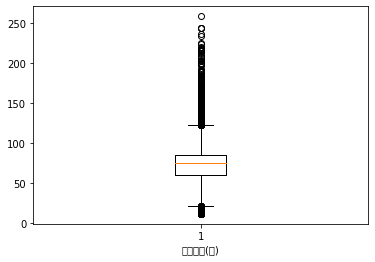

In [ ]:
#@title 이상치

box=['전용면적(㎡)']

for i in box:
  plt.boxplot(df_apt1[i])
  plt.xlabel(i)
  plt.show()

In [ ]:
#@title get_dummies 쓰면. . . 이따구로 나와요 화가 나

df_apt_1 = pd.get_dummies(df_apt1, columns= df_apt1.describe(include='O').columns)
    #drop_first=True

df_apt_1
# df_apt1_2 = pd.get_dummies(df_apt1, columns=df_apt1.describe(include='O').columns)
# df_apt1_2

In [ ]:
X = df_apt1.drop('거래금액(만원)', axis=1) 
y = df_apt1['거래금액(만원)']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=230)

In [ ]:
#@title 크롤링 하려다가 ~^_^

# import requests
# from bs4 import BeautifulSoup

# # 크롤링할 페이지 URL
# url = "https://www.google.com/search?q=2022%EB%85%84%2C+2023%EB%85%84+%EA%B8%B0%EC%A4%80%EA%B8%88%EB%A6%AC&oq=2022%EB%85%84%2C+2023%EB%85%84+%EA%B8%B0%EC%A4%80%EA%B8%88%EB%A6%AC&aqs=chrome..69i57j0i512l4j0i30j0i8i30l4.6905j1j7&sourceid=chrome&ie=UTF-8"

# # requests 라이브러리를 사용하여 HTML 코드 가져오기
# response = requests.get(url)
# html = response.text

# # BeautifulSoup 라이브러리를 사용하여 HTML 파싱
# soup = BeautifulSoup(html, "html.parser")

# # 최신 데이터 출력하기
# table = soup.find_all("table", {"class": "ztXv9"})

# for tr in table[0].find_all("tr"):
#     td_list = tr.find_all("td")
#     if len(td_list) == 5:
#         print(td_list[0].text.strip(), td_list[2].text.strip())